Running in Colab environment.

It expects to find the data in the google drive linked with the Colab account. In the google drive, the data should be in '/Kaggle/train/' and '/Kaggle/test/'

In [1]:
import numpy as np

import torch
import torch.nn as nn

import glob
import cv2
import os
import csv

import torchvision.models as models
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Prepare data

In [3]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [72]:
TRANSFORM_IMG = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [6]:
class TrainDataset(torch.utils.data.Dataset):

    def __init__(self, root_path, transform=None):
        self.data_paths = glob.glob("/content/gdrive/MyDrive/Kaggle/train/*/*")
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.data_paths[idx])
        label = self.data_paths[idx].split("/")[-2]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(int(label))

    def __len__(self):
        return len(self.data_paths)

In [73]:
train_data = TrainDataset(root_path='/content/gdrive/MyDrive/Kaggle/train', transform=TRANSFORM_IMG['train'])
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)

## Loss

In [13]:
# Loss Function
def loss_function(predictions, targets):
    
    criterion = nn.CrossEntropyLoss()
    return criterion(predictions, targets)

## Train

In [14]:
# CNN Training
#
# Inputs:
#    epoch: epoch #
#    model
#    optimizer
#
# Outputs:
#    loss
#
def cnn_train(epoch, model, optimizer):

    total_loss = 0
    model.train()
    
    for batch_idx, (img, category) in enumerate(train_loader):
        optimizer.zero_grad()
        
        img = img.to(device)
        category = category.to(device)
        output = model(img)
        
        loss = loss_function(output, category)
        loss.backward()
        total_loss += loss.item()
        
        optimizer.step()
        
        if batch_idx % 3 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(img), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(img)))

    average_loss = total_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average Loss: {:.4f}'.format(
          epoch, average_loss))
    
    return average_loss

## Main

In [74]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
model = models.resnet50(pretrained=True)

In [75]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(2048, 22)
model = model.to(device)

Train Epoch: 1 [0/110 (0%)]	Loss: 0.312081
Train Epoch: 1 [30/110 (27%)]	Loss: 0.365820
Train Epoch: 1 [60/110 (55%)]	Loss: 0.394641
Train Epoch: 1 [90/110 (82%)]	Loss: 0.337948
====> Epoch: 1 Average Loss: 0.3717
Train Epoch: 2 [0/110 (0%)]	Loss: 0.350949
Train Epoch: 2 [30/110 (27%)]	Loss: 0.319180
Train Epoch: 2 [60/110 (55%)]	Loss: 0.332169
Train Epoch: 2 [90/110 (82%)]	Loss: 0.340402
====> Epoch: 2 Average Loss: 0.3412
Train Epoch: 3 [0/110 (0%)]	Loss: 0.303413
Train Epoch: 3 [30/110 (27%)]	Loss: 0.306668
Train Epoch: 3 [60/110 (55%)]	Loss: 0.291165
Train Epoch: 3 [90/110 (82%)]	Loss: 0.314932
====> Epoch: 3 Average Loss: 0.3115
Train Epoch: 4 [0/110 (0%)]	Loss: 0.272716
Train Epoch: 4 [30/110 (27%)]	Loss: 0.275422
Train Epoch: 4 [60/110 (55%)]	Loss: 0.326942
Train Epoch: 4 [90/110 (82%)]	Loss: 0.287332
====> Epoch: 4 Average Loss: 0.3031
Train Epoch: 5 [0/110 (0%)]	Loss: 0.277900
Train Epoch: 5 [30/110 (27%)]	Loss: 0.281161
Train Epoch: 5 [60/110 (55%)]	Loss: 0.297718
Train Epoch

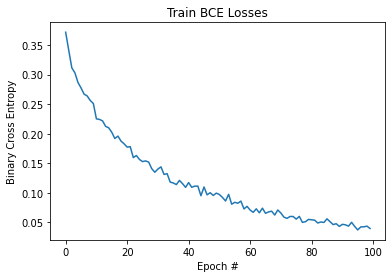

In [76]:
# train and test cnn
epochs = 100
average_train_losses = []

optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)

for epoch in range(1, epochs + 1):
    average_train_loss = cnn_train(epoch, model, optimizer)
    average_train_losses.append(average_train_loss)

# plot the average train loss
plt.plot(average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.show()

## Predictions

In [77]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self, root_path, transform=None):
        self.data_paths = glob.glob("/content/gdrive/MyDrive/Kaggle/test/*")
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.data_paths[idx])
        label = self.data_paths[idx].split("/")[-1][:-4]
        if self.transform:
            img = self.transform(img)
        return img, int(label)

    def __len__(self):
        return len(self.data_paths)

# prepare test image
test_data = MyDataset(root_path='/content/gdrive/MyDrive/Kaggle/test', transform=TRANSFORM_IMG['test'])
test_loader = DataLoader(test_data, shuffle=False)

In [78]:
# Test
results = []

model.eval()
with torch.no_grad():
    for i, (img, img_id) in enumerate(test_loader):
        img = img.to(device)
        pred = model(img).argmax()
        results.append([int(img_id[0]), int(pred)])

## Export result

In [81]:
header = ['id', 'category']
results.sort(key=lambda s:s[0])

with open('result.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerows(results)
    